## Import Libraries

In [1]:
! /opt/conda/envs/py39/bin/python -m pip install pandas_ta

In [2]:
import gym
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta
from stockstats import StockDataFrame as Sdf
from finrl.agents.stablebaselines3.models import A2C

from finrl.agents.stablebaselines3.models import DummyVecEnv
from sklearn.preprocessing import StandardScaler

## Importing local modules

In [3]:
import os
import sys
sys.path.append('../')
from src.rl_env.stock import SingleStockEnv
from src.models.models import RLModels
from src.data.make_dataset import download_stock_data

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [63]:
data_df = pd.read_csv('../data/snp.csv')[['Date','Close']].rename({'Date':'date','Close':'adjcp'}, axis = 1)

In [64]:
data_df

,date,adjcp
0,2017-08-17,2430.01
1,2017-08-18,2425.55
2,2017-08-19,2425.55
3,2017-08-20,2425.55
4,2017-08-21,2428.37
...,...,...
2049,2023-03-25,3970.99
2050,2023-03-26,3970.99
2051,2023-03-27,3977.53
2052,2023-03-28,3971.27


In [65]:
data_df['rsi'] = ta.rsi(data_df['adjcp'])

In [66]:
data_df['macd'] = ta.macd(data_df['adjcp'])['MACD_12_26_9']

In [67]:
data_df.fillna(0, inplace=True)

In [68]:
data_clean = data_df.copy()

In [69]:
train = data_clean[(data_clean.date>='2017-08-17') & (data_clean.date<'2022-03-29')]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [70]:
model_list = ['ddpg','ppo','a2c']

In [71]:
model_dict = {}
for m in model_list:
    print(30*"=", m, 30*"=")
    env_train = DummyVecEnv([lambda: SingleStockEnv(train,feat_list=['macd','rsi'])])
    model = RLModels(m, env_train)
    model.train(total_timesteps=200000)
    model.save('AAPL_ppo_100k')
    model_dict.update({m:model})

============================== ddpg ==============================
previous_total_asset:100000
end_total_asset:100383.87352817338
total_reward:383.8735281733825
total_cost:  2225.9670294750454
total trades:  73
Sharpe:  0.06594792306724609
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0


KeyboardInterrupt: 

In [15]:
test = data_clean[(data_clean.date>='2022-03-29') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

### Testing

In [16]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \ # 252 trading days
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [46]:
cum_return = {}
for m in model_list:
    model = model_dict[m]
    env_test = DummyVecEnv([lambda: SingleStockEnv(test,feat_list=['macd','rsi'])])
    obs_test = env_test.reset()
    print("==============Model Prediction===========")
    for i in range(len(test.index.unique())):
        
        action, _states = model.predict(obs_test)
        obs_test, rewards, dones, info = env_test.step(action)
        env_test.render()
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    
    cum_return.update({m: (df_total_value.account_value.pct_change(1)+1).cumprod()-1})

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:668641.2476990585
total_reward:568641.2476990585
total_cost:  99.89105673980714
total trades:  456
Sharpe:  1.8128801890896051
==============Model Prediction===========
previous_total_asset:100000
end_total_asset:714423.9892513908
total_reward:614423.9892513908
total_cost:  1646.5481590020722
total trades:  455
Sharpe:  1.9002853736162395
==============Model Prediction===========
previous_total_asset:100000
end_total_asset:613741.1657255914
total_reward:513741.16572559136
total_cost:  3640.631477344967
total trades:  456
Sharpe:  1.7945040987727845


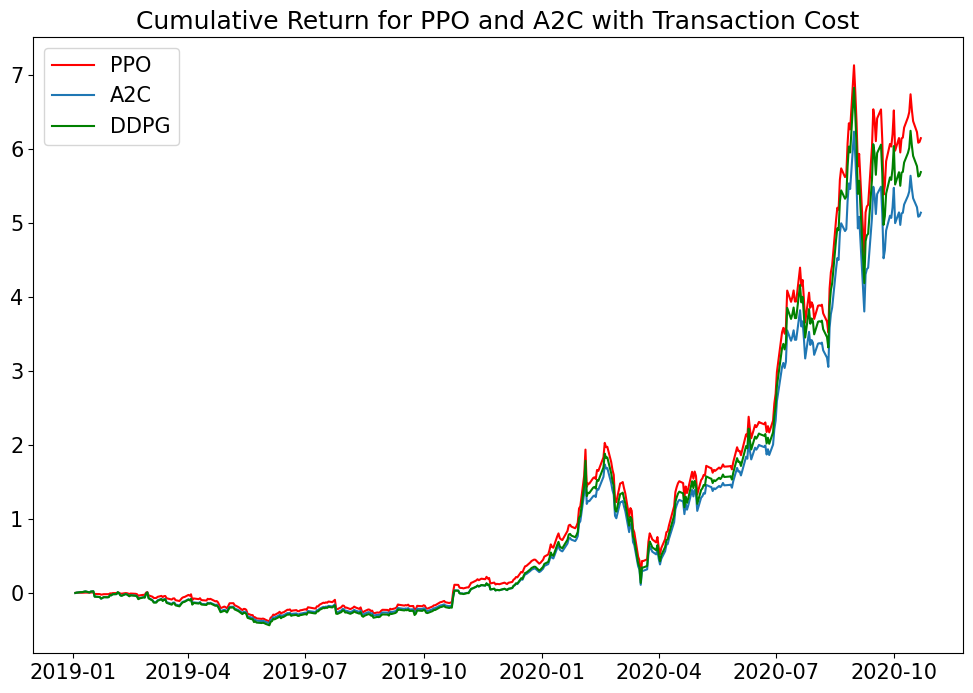

In [47]:

%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.date, cum_return['ppo'], color='red',label = "PPO")
plt.plot(test.date, cum_return['a2c'], label = "A2C")
plt.plot(test.date, cum_return['ddpg'], color = 'green', label = "DDPG")

plt.title("Cumulative Return for PPO and A2C with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)



## With correlation

In [84]:
bit_cor_df = pd.read_csv('../data/SnP_bit_corr.csv', usecols=['Date','correlation']).rename({'Date':'date', 'correlation':'cor_bit'}, axis = 1)

In [85]:
eth_cor_df = pd.read_csv('../data/SnP_eth_corr.csv', usecols=['Date','correlation']).rename({'Date':'date', 'correlation':'cor_eth'}, axis = 1)

In [88]:
bit_cor_df

,date,cor_bit
0,2017-08-17,NaN
1,2017-08-18,NaN
2,2017-08-19,NaN
3,2017-08-20,NaN
4,2017-08-21,NaN
...,...,...
2049,2023-03-25,0.695852
2050,2023-03-26,0.614008
2051,2023-03-27,NaN
2052,2023-03-28,NaN


In [94]:
df_corr = pd.concat([data_clean, bit_cor_df['cor_bit'],eth_cor_df['cor_eth']], axis = 1).dropna()

In [96]:
train = df_corr[(data_clean.date>='2017-08-17') & (df_corr.date<'2022-03-29')]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [98]:
model_dict = {}
for m in model_list:
    print(30*"=", m, 30*"=")
    env_train = DummyVecEnv([lambda: SingleStockEnv(train,feat_list=['macd','rsi','cor_bit','cor_eth'])])
    model = RLModels(m, env_train)
    model.train(total_timesteps=200000)
    model.save('AAPL_ppo_100k')
    model_dict.update({m:model})

============================== ddpg ==============================
previous_total_asset:100000
end_total_asset:165657.02391571173
total_reward:65657.02391571173
total_cost:  2738.4279195342447
total trades:  1650
Sharpe:  0.536028731149511
previous_total_asset:100000
end_total_asset:184618.89640000003
total_reward:84618.89640000003
total_cost:  98.3036
total trades:  1673
Sharpe:  0.6346246765080173
previous_total_asset:100000
end_total_asset:184618.89640000003
total_reward:84618.89640000003
total_cost:  98.3036
total trades:  1673
Sharpe:  0.6346246765080173
previous_total_asset:100000
end_total_asset:184618.89640000003
total_reward:84618.89640000003
total_cost:  98.3036
total trades:  1673
Sharpe:  0.6346246765080173


KeyboardInterrupt: 

In [ ]:
test = df_corr[(df_corr.date>='2022-03-29') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [ ]:
cum_return = {}
for m in model_list:
    model = model_dict[m]
    env_test = DummyVecEnv([lambda: SingleStockEnv(test,feat_list=['macd','rsi'])])
    obs_test = env_test.reset()
    print("==============Model Prediction===========")
    for i in range(len(test.index.unique())):
        
        action, _states = model.predict(obs_test)
        obs_test, rewards, dones, info = env_test.step(action)
        env_test.render()
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    
    cum_return.update({m: (df_total_value.account_value.pct_change(1)+1).cumprod()-1})